# Справочник

## Токенизатор

В Yargy токенизатор реализован на регулярных выражениях. Для каждого типа токенов есть своё правило со своей регуляркой:

In [1]:
from yargy.tokenizer import RULES


RULES

[TokenRule('RU', '[а-яё]+'),
 TokenRule('LATIN', '[a-z]+'),
 TokenRule('INT', '\\d+'),
 TokenRule('PUNCT',
           '[-\\\\/!#$%&()\\[\\]\\*\\+,\\.:;<=>?@^_`{|}~№…"\\\'«»„“ʼʻ”]'),
 TokenRule('EOL', '[\\n\\r]+'),
 TokenRule('OTHER', '\\S')]

Токенизатор инициализируется списком правил. По-умолчанию — это `RULES`:

In [2]:
from yargy.tokenizer import Tokenizer


text = 'a@mail.ru'
tokenizer = Tokenizer()
list(tokenizer(text))

[Token('a', [0, 1), 'LATIN'),
 Token('@', [1, 2), 'PUNCT'),
 Token('mail', [2, 6), 'LATIN'),
 Token('.', [6, 7), 'PUNCT'),
 Token('ru', [7, 9), 'LATIN')]

Пользователь может убрать часть правил из списка или добавить новых. Например, нужно убрать токены с переводами строк:

In [3]:
tokenizer = Tokenizer()

text = '''
abc
123
'''
list(tokenizer(text))

[Token('\n', [0, 1), 'EOL'),
 Token('abc', [1, 4), 'LATIN'),
 Token('\n', [4, 5), 'EOL'),
 Token('123', [5, 8), 'INT'),
 Token('\n', [8, 9), 'EOL')]

Уберём правило для `'EOL'`:

In [4]:
tokenizer = Tokenizer().remove_types('EOL')

list(tokenizer(text))

[Token('abc', [1, 4), 'LATIN'), Token('123', [5, 8), 'INT')]

В Yargy есть примитивные правила для токенизации емейлов и телефонов. По-умолчанию они не используются:

In [5]:
from yargy.tokenizer import EMAIL_RULE, PHONE_RULE


text = 'email: ab@mail.ru call: 8 915 132 54 76'
tokenizer = Tokenizer().add_rules(EMAIL_RULE, PHONE_RULE)
list(tokenizer(text))

[Token('email', [0, 5), 'LATIN'),
 Token(':', [5, 6), 'PUNCT'),
 Token('ab@mail.ru', [7, 17), 'EMAIL'),
 Token('call', [18, 22), 'LATIN'),
 Token(':', [22, 23), 'PUNCT'),
 Token(' 8 915 132 54 76', [23, 39), 'PHONE')]

Можно создать и добавить своё правило. Например, так выглядит простое решение для извлечения доменов:

In [6]:
from yargy.tokenizer import TokenRule


DOMAIN_RULE = TokenRule('DOMAIN', '[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+')

    
text = 'на сайте www.VKontakte.ru'
tokenizer = Tokenizer().add_rules(DOMAIN_RULE)
list(tokenizer(text))

[Token('на', [0, 2), 'RU'),
 Token('сайте', [3, 8), 'RU'),
 Token('www.VKontakte.ru', [9, 25), 'DOMAIN')]

По умолчанию, Yargy использует не `Tokenizer`, а `MorphTokenizer`. Для каждого токена с типом `'RU'` он определяет морфологию с помощью pymorphy2:

In [7]:
from yargy.tokenizer import MorphTokenizer

tokenizer = MorphTokenizer()
list(tokenizer('X век стал'))

[Token('X', [0, 1), 'LATIN'),
 MorphToken('век',
            [2, 5),
            'RU',
            [Form('век', Grams(NOUN,inan,masc,nomn,sing)),
             Form('век', Grams(NOUN,accs,inan,masc,sing)),
             Form('век', Grams(ADVB)),
             Form('веко', Grams(NOUN,gent,inan,neut,plur))]),
 MorphToken('стал',
            [6, 10),
            'RU',
            [Form('стать', Grams(VERB,indc,intr,masc,past,perf,sing))])]

## Газеттир

При составлении правил часто используются списки слов и словосочетаний. Например, словарь профессий или географических объектов. Такие правила можно записывать стандартные средствами через `rule`, `or_`, `normalized`, `caseless`:

In [8]:
from yargy import rule, or_
from yargy.predicates import normalized, caseless


POSITION = or_(
    rule(normalized('генеральный'), normalized('директор')),
    rule(normalized('бухгалтер'))
)

GEO = or_(
    rule(normalized('Ростов'), '-', caseless('на'), '-', caseless('Дону')),
    rule(normalized('Москва'))
)

Это неудобно и легко ошибиться. Для составления словарей в Yargy используется газеттир. Реализовано два типа газеттиров: `morph_pipeline` и `caseless_pipeline`. `morph_pipeline` перед работой приводит слова к нормальной форме:

In [9]:
from yargy import Parser
from yargy.pipelines import morph_pipeline


TYPE = morph_pipeline(['электронный дневник'])

parser = Parser(TYPE)
text = 'электронным дневником, электронные дневники, электронное дневнику'
for match in parser.findall(text):
    print([_.value for _ in match.tokens])

['электронным', 'дневником']
['электронные', 'дневники']
['электронное', 'дневнику']


`caseless_pipeline` используется, когда слова не нужно приводить к нормальной форме. Например, есть арабские имена: "Абд Аль-Азиз Бин Мухаммад", "Абд ар-Рахман Наср ас-Са ди". Их нужно обработать как есть: 

In [10]:
from yargy.pipelines import caseless_pipeline


NAME = caseless_pipeline([
    'Абд Аль-Азиз Бин Мухаммад',
    'Абд ар-Рахман Наср ас-Са ди'
])
    
parser = Parser(NAME)
text = 'Абд Аль-Азиз Бин Мухаммад, АБД АР-РАХМАН НАСР АС-СА ДИ'
for match in parser.findall(text):
    print([_.value for _ in match.tokens])

['АБД', 'АР', '-', 'РАХМАН', 'НАСР', 'АС', '-', 'СА', 'ДИ']
['Абд', 'Аль', '-', 'Азиз', 'Бин', 'Мухаммад']


## Предикаты

## Интерпретация

Схема объекта, который получается в результате интерпретации описывается конструктором `fact`. Чтобы задать значение поля по-умолчанию, используется метод `attribute`. Например, в `Date` по-умолчанию год будет равен 2017:

In [11]:
from IPython.display import display
from yargy import Parser, rule, and_, or_
from yargy.interpretation import fact, attribute
from yargy.predicates import dictionary, gte, lte


Date = fact(
    'Date',
    [attribute('year', 2017), 'month', 'day']
)


MONTHS = {
    'январь',
    'февраль',
    'март',
    'апрель',
    'мая',
    'июнь',
    'июль',
    'август',
    'сентябрь',
    'октябрь',
    'ноябрь',
    'декабрь'
}


MONTH_NAME = dictionary(MONTHS)
DAY = and_(
    gte(1),
    lte(31)
)
YEAR = and_(
    gte(1900),
    lte(2100)
)
DATE = rule(
    DAY.interpretation(
        Date.day
    ),
    MONTH_NAME.interpretation(
        Date.month
    ),
    YEAR.interpretation(
        Date.year
    ).optional()
).interpretation(
    Date
)


text = '''18 июля 2016
15 марта
'''
parser = Parser(DATE)
for line in text.splitlines():
    match = parser.match(line)
    display(match.fact)

Date(year='2016',
     month='июля',
     day='18')

Date(year=2017,
     month='марта',
     day='15')

Для дат деревья разбора выглядят просто: вершина-конструктор и несколько детей-атрибутов:

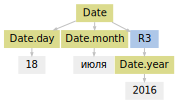

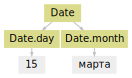

In [12]:
parser = Parser(DATE)
for line in text.splitlines():
    match = parser.match(line)
    display(match.tree.as_dot)

Как будет себя вести алгоритм интерпретации, когда ребёнок конструктора не атрибут, а другой конструктор? Или когда ребёнок атрибута другой атрибут? Или когда под конструктором или атрибутом не одна, а несколько вершин с токенами? Пойдём от простого к сложному. Когда под вершиной-атрибутом несколько токенов, они объединяются:

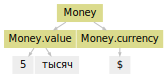

In [13]:
from yargy.predicates import eq, type, dictionary


Money = fact(
    'Money',
    ['value', 'currency']
)
MONEY = rule(
    rule(
        type('INT'),
        dictionary({
            'тысяча',
            'миллион'
        })
    ).interpretation(
        Money.value
    ),
    eq('$').interpretation(
        Money.currency
    )
).interpretation(
    Money
)

parser = Parser(MONEY)
match = parser.match('5 тысяч$')
match.tree.as_dot

В `Money.value` будет два слова:

In [14]:
match.fact

Money(value='5 тысяч',
      currency='$')

Когда под вершиной-атрибутом смесь из токенов и вершин-конструктов, интерпретация падает:

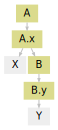

In [15]:
from yargy.predicates import true


A = fact(
    'A',
    ['x']
)
B = fact(
    'B',
    ['y']
)
RULE = rule(
    true(),
    true().interpretation(
        B.y
    ).interpretation(
        B
    )
).interpretation(
    A.x
).interpretation(
    A
)

parser = Parser(RULE)
match = parser.match('X Y')
match.tree.as_dot

In [16]:
# match.fact Будет TypeError

Если под вершиной-атрибутом другая вершина-атрибут, нижняя просто исчезает:

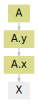

In [17]:
from yargy.predicates import true


A = fact(
    'A',
    ['x', 'y']
)
RULE = true().interpretation(
    A.x
).interpretation(
    A.y
).interpretation(A)

parser = Parser(RULE)
match = parser.match('X')
match.tree.as_dot

"X" попадёт в `A.y`, не в `A.x`:

In [18]:
match.fact

A(x=None,
  y='X')

Что если под вершиной-конструктом несколько одинаковых вершин-атрибутов? Самый правый атрибут перезаписывает все остальные:

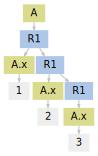

In [19]:
A = fact(
    'A',
    ['x']
)
RULE = true().interpretation(
    A.x
).repeatable().interpretation(
    A
)

parser = Parser(RULE)
match = parser.match('1 2 3')
match.tree.normalized.as_dot

В `A.x` попадёт 3:

In [20]:
match.fact

A(x='3')

Но бывает нужно сохранить содержание всех повторяющихся вершин-атрибутов, не только самой правой. В этом случае поле помечается как `repeatable`:

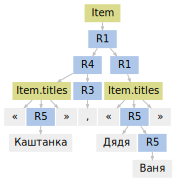

In [21]:
from yargy import not_


Item = fact(
    'Item',
    [attribute('titles').repeatable()]
)

TITLE = rule(
    '«',
    not_(eq('»')).repeatable(),
    '»'
)
ITEM = rule(
    TITLE.interpretation(
        Item.titles
    ),
    eq(',').optional()
).repeatable().interpretation(
    Item
)

parser = Parser(ITEM)
text = '«Каштанка», «Дядя Ваня»'
match = parser.match(text)
match.tree.as_dot

«Дядя Ваня» не перезапишет «Каштанка», они оба окажутся в `Item.titles`:

In [22]:
match.fact

Item(titles=['«Каштанка»', '«Дядя Ваня»'])

Остался последний неочевидный случай, когда ребёнок вершины-конструктора, другая вершина-конструктор. Такая ситуация возникает при использовании рекурсивных грамматик. В примере ребёнок вершины `Item` другая вершина `Item`:

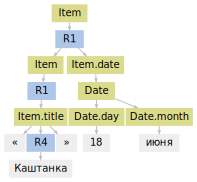

In [23]:
from yargy import forward, or_

Item = fact(
    'Item',
    ['title', 'date']
)

ITEM = forward().interpretation(
    Item
)
ITEM.define(or_(
    TITLE.interpretation(
        Item.title
    ),
    rule(ITEM, TITLE),
    rule(
        ITEM,
        DATE.interpretation(
            Item.date
        )
    )
))

parser = Parser(ITEM)
text = '«Каштанка» 18 июня'
match = parser.match(text)
match.tree.as_dot

В ходе интерпретации появится два объекта: `Item(title='«Каштанка»', date=None)` и `Item(title=None, date=Date('18', 'июня'))`. В конце произойдёт слияние:

In [24]:
match.fact

Item(title='«Каштанка»',
     date=Date(year=2017,
               month='июня',
               day='18'))

## Нормализация

В Yargy реализованы четыре основных метода для нормализации: `normalized`, `inflected`, `custom` и `const`. `normalized` возвращает нормальную форму слова, соответствует `normal_form` в pymorphy2:

In [25]:
DATE = rule(
    DAY.interpretation(
        Date.day
    ),
    MONTH_NAME.interpretation(
        Date.month
    ),
    YEAR.interpretation(
        Date.year
    )
).interpretation(
    Date
)

parser = Parser(DATE)
match = parser.match('8 июня 2015')
match.fact

Date(year='2015',
     month='июня',
     day='8')

С `normalized` слово "июня" меняется на "июнь":

In [26]:
DATE = rule(
    DAY.interpretation(
        Date.day
    ),
    MONTH_NAME.interpretation(
        Date.month.normalized()
    ),
    YEAR.interpretation(
        Date.year
    )
).interpretation(
    Date
)

parser = Parser(DATE)
match = parser.match('8 июня 2015')
match.fact

Date(year='2015',
     month='июнь',
     day='8')

Если в `normalized` попадает несколько токенов, каждый приводится к нормальной форме по отдельности:

In [27]:
from yargy.interpretation import fact
from yargy.predicates import normalized
from IPython.display import display


Geo = fact(
    'Geo',
    ['name']
)

RULE = rule(
    normalized('Красная'),
    normalized('площадь')
).interpretation(
    Geo.name.normalized()
).interpretation(
    Geo
)

parser = Parser(RULE)
for match in parser.findall('на Красной площади'):
    display(match.fact)

Geo(name='красный площадь')

Особым образом ведёт себя `normalized`, когда идёт после газеттира. Результатом нормализации тогда будет ключ газеттира:

In [28]:
from yargy.pipelines import morph_pipeline

RULE = morph_pipeline([
    'красная площадь',
    'первомайская улица'
]).interpretation(
    Geo.name.normalized()
).interpretation(
    Geo
)

parser = Parser(RULE)
for match in parser.findall('c Красной площади на Первомайскую улицу'):
    display(match.fact)

Geo(name='красная площадь')

Geo(name='первомайская улица')

`inflected` склоняет слово, соответствует методу `inflect` в pymorphy2:

In [29]:
from yargy.interpretation import fact
from yargy.predicates import gram

Name = fact(
    'Name',
    ['first']
)

NAME = gram('Name').interpretation(
    Name.first.inflected()
).interpretation(
    Name
)

parser = Parser(NAME)
for match in parser.findall('Саше, Маше, Вадиму'):
    display(match.fact)

Name(first='саша')

Name(first='маша')

Name(first='вадим')

В качестве аргумента `inflected` принимает набор граммем:

In [30]:
NAME = gram('Name').interpretation(
    Name.first.inflected({'accs', 'plur'})  # винительный падеж, множественное число
).interpretation(
    Name
)

parser = Parser(NAME)
for match in parser.findall('Саша, Маша, Вадим'):
    display(match.fact)

Name(first='саш')

Name(first='маш')

Name(first='вадимов')

`custom` применяет к слову произвольную функцию:

In [31]:
from yargy.interpretation import fact
from yargy.predicates import type

Float = fact(
    'Float',
    ['value']
)


INT = type('INT')
FLOAT = rule(
    INT,
    '.',
    INT
).interpretation(
    Float.value.custom(float)
).interpretation(
    Float
)

parser = Parser(FLOAT)
match = parser.match('3.1415')
match.fact

Float(value=3.1415)

`custom` может применяться вместе с `normalized`. Тогда слово начала будет поставлено в нормальную форму, потом к нему будет применена функция:

In [32]:
MONTHS = {
    'январь': 1,
    'февраль': 2,
    'март': 3,
    'апрель': 4,
    'мая': 5,
    'июнь': 6,
    'июль': 7,
    'август': 8,
    'сентябрь': 9,
    'октябрь': 10,
    'ноябрь': 11,
    'декабрь': 12
}

DATE = rule(
    DAY.interpretation(
        Date.day.custom(int)
    ),
    MONTH_NAME.interpretation(
        Date.month.normalized().custom(MONTHS.__getitem__)
    ),
    YEAR.interpretation(
        Date.year.custom(int)
    )
).interpretation(
    Date
)

parser = Parser(DATE)
match = parser.match('8 июня 2015')
match.fact

Date(year=2015,
     month=6,
     day=8)

`const` просто заменяет слово или словосочетания фиксированным значением:

In [33]:
Era = fact(
    'Era',
    ['value']
)

BC = morph_pipeline([
    'до нашей эры',
    'до н.э.'
]).interpretation(
    Era.value.const('BC')
)
AD = morph_pipeline([
    'наша эра',
    'н.э.'
]).interpretation(
    Era.value.const('AD')
)
ERA = or_(
    BC,
    AD
).interpretation(
    Era
)

parser = Parser(ERA)
for match in parser.findall('наша эра, до н.э.'):
    display(match.fact)

Era(value='BC')

Era(value='AD')

## Согласование 

В Yargy реализовано четыре типа согласований: `gender_relation` — согласование по роду, `number_relation` — по числу, `case_relation` — по падежу, `gnc_relation` — по роду, числу и падежу. Ограничение на правило указывается с помощью метода `match`:

Name(first='саша',
     last='иванова')

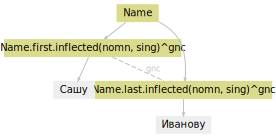

In [34]:
from yargy.relations import gnc_relation

Name = fact(
    'Name',
    ['first', 'last']
)

gnc = gnc_relation()

NAME = rule(
    gram('Name').interpretation(
        Name.first.inflected()
    ).match(gnc),
    gram('Surn').interpretation(
        Name.last.inflected()
    ).match(gnc)
).interpretation(
    Name
)

parser = Parser(NAME)
match = parser.match('Сашу Иванову')
display(match.fact)
display(match.tree.as_dot)

Для указания главного слова в фразе используется пометка `main`. По-умолчанию главное слово — самое левое:

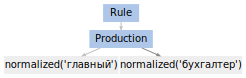

In [35]:
from yargy.relations import main

POSITION = rule(
    normalized('главный'),
    main(normalized('бухгалтер'))
)

POSITION.as_dot

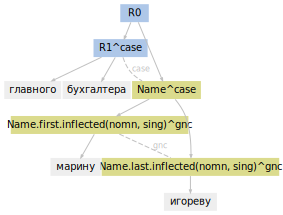

In [36]:
from yargy.relations import case_relation

case = case_relation()

PERSON = rule(
    POSITION.match(case),
    NAME.match(case)
)


parser = Parser(PERSON)
assert not parser.match('главного бухгалтер марину игореву')

match = parser.match('главного бухгалтера марину игореву')
match.tree.as_dot